### Подготовка

In [1]:
!wget https://data.deepai.org/PascalVOC2012.zip
!unzip PascalVOC2012.zip
!mv voc2012 VOCdevkit

--2023-03-30 12:58:44--  https://data.deepai.org/PascalVOC2012.zip
Resolving data.deepai.org (data.deepai.org)... 185.93.1.250, 2400:52e0:1a00::1067:1
Connecting to data.deepai.org (data.deepai.org)|185.93.1.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899239928 (3.6G) [application/zip]
Saving to: ‘PascalVOC2012.zip.1’

PascalVOC2012.zip.1  46%[========>           ]   1.68G  5.20MB/s    eta 5m 53s ^C
Archive:  PascalVOC2012.zip
replace VOC2012/Annotations/2007_000027.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat 'voc2012': No such file or directory


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"
    
# Параметры тренировки и визуализации.
TRAIN = True  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.13.1+cu116
Use CUDA


In [5]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Mask values: {0, 19, 255}


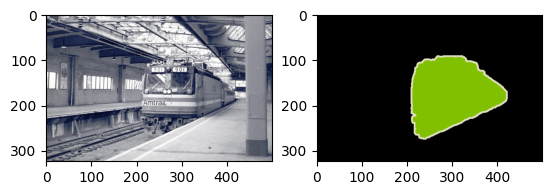

In [6]:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [7]:
class Scaler(object):

    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

In [8]:
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask

### Аугментации

In [9]:
from skimage.transform import rotate

class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.
    
    
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask

# добавлю свои аугментации: сдвиг + to_gray + поворот

class OffsetAugmentation(object):
    def __call__(self, image, mask):
        image = np.array(image)
        mask = np.array(mask)

        offset_x = np.random.randint(-50, 50) 
        offset_y = np.random.randint(-50, 50)

        new_image = np.concatenate((image[-offset_x:, :], image[:-offset_x, :]), axis=0)
        new_image = np.concatenate((image[:, -offset_y:], image[:, :-offset_y]), axis=1)

        new_mask = np.concatenate((mask[-offset_x:, :], mask[:-offset_x, :]), axis=0)
        new_mask = np.concatenate((mask[:, -offset_y:], mask[:, :-offset_y]), axis=1)

        return new_image.clip(0, 255).astype(np.uint8), new_mask.clip(0, 255).astype(np.uint8)


class GrayAugmentation(object):
    def __call__(self, image, mask):
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        new_image = new_image[..., None]
        new_image = np.concatenate((new_image, new_image, new_image), axis=-1)
        return new_image, mask


class RotateAugmentation(object):
    def __call__(self, image, mask):
        angle = np.random.randint(-15, 16)

        new_image = rotate(image, angle)
        new_mask = rotate(mask, angle)

        return new_image, new_mask



class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)

### Dataset

In [10]:
def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    #if len(result.shape) == 3:
    result = result.permute(2, 0, 1)
    return result

  
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    #if len(image.shape) == 3:
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    #return image.to(torch.uint8).cpu().numpy()

In [11]:
class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
          # + мои 3 аугментации
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter(),
                                                 OffsetAugmentation(),
                                                 RotateAugmentation(),
                                                 GrayAugmentation())
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = image_to_torch(image).float() - 0.5
        mask = image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True, augment=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


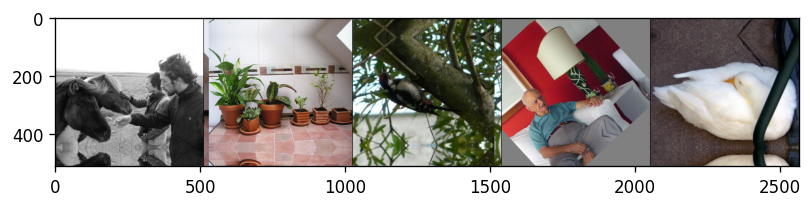

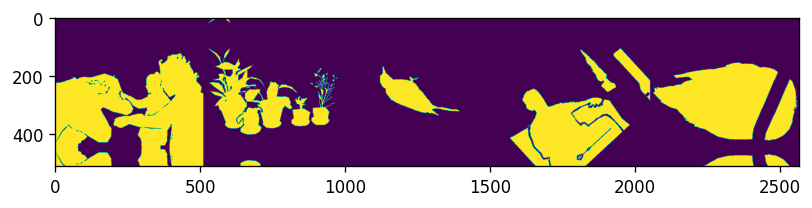

In [12]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(image_to_numpy(image))
        masks.append(image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
valset.set_padding(0)
show_dataset(trainset)

Кстати тут видно и мои аугментации, первая это to_gray, вторая сдвиг, и 4 поворот

In [13]:
from torch.utils.data import DataLoader

In [14]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model

In [15]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from timm.scheduler import TanhLRScheduler
from pytorch_lightning.callbacks import LearningRateMonitor

In [16]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

In [33]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()
                
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.

        loss = self._bce(predicted.squeeze(1), masks.float())        
        return loss

In [36]:
class meanIoU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)  
        predicted = [i.detach().cpu().apply_(lambda x: int(x >= 0.5)).to(torch.long) for i in predicted]      
        results = []
        for pred, mask in zip(predicted, masks):
            pred = pred.to(DEVICE)
            results.append(torch.sum(pred & mask).item() / torch.sum(pred | mask).item())
        return np.mean(results)

class DICELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def __call__(self, pred, masks):
        smooth = 1e-9
        pred, masks = crop_images(pred, masks) 
        N = masks.size(0)
        pred_flat = pred.view(N, -1)
        masks_flat = masks.view(N, -1)
    
        intersection = (pred_flat * masks_flat).sum(1)
        unionset = pred_flat.sum(1) + masks_flat.sum(1)
        loss = 2 * (intersection + smooth) / (unionset + smooth)
    
        return loss.sum() / N
 
    

In [37]:
from torchvision.models.segmentation import deeplabv3_resnet50

In [47]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
                
        self.model = deeplabv3_resnet50(weights=None)
        self.model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
        
        self.iou = meanIoU()

        self.bce_loss = BCELoss()
        self.dice_loss = DICELoss()
        self.criterion = lambda preds, masks: (self.bce_loss(preds, masks) + self.dice_loss(preds, masks)) #BCELoss()
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache()

        images, masks = batch
        preds = self.model(images)
        loss = self.criterion(preds['out'], masks)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache()

        images, masks = batch
        preds = self.model(images)
        loss = self.criterion(preds['out'], masks)
        self.log("validation_loss", loss, sync_dist=True)
        # IoU metric
        self.log("validation_IoU", self.iou(preds['out'], masks), sync_dist=True)
        
    def forward(self, images):
        torch.cuda.empty_cache()

        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        #preds = [i.detach().cpu().apply_(lambda x: int(x >= 0.5)).to(torch.long) for i in preds['out']]
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [48]:
# model
pl_model = SegmentationModel(3e-4)
checkpoint_callback = ModelCheckpoint(monitor='validation_IoU',mode='max',  save_top_k=3)
last_checkpoint = ModelCheckpoint(mode='max', monitor='time_log', save_top_k=1)

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 5, accelerator=DEVICE, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | model     | DeepLabV3 | 39.6 M
1 | iou       | meanIoU   | 0     
2 | bce_loss  | BCELoss   | 0     
3 | dice_loss | DICELoss  | 0     
----------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.535   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

In [ ]:
# model = deeplabv3_resnet50(weights=None)
# model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# images, masks = next(iter(train_loader))
# print(images.shape, masks.shape)

# torch.cuda.empty_cache()

# model.to(DEVICE)
# pred = model(images.to(DEVICE))

In [ ]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))['out'][0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

In [ ]:
show_segmentations(pl_model, valset)